In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [2]:
dss = [xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data-params').expanduser().glob('*.nc')]

In [23]:
ds = xr.open_dataset(Path('~/scratch/spicy/SnowEx-Data-params/Banner_2020-02-18.nc'))

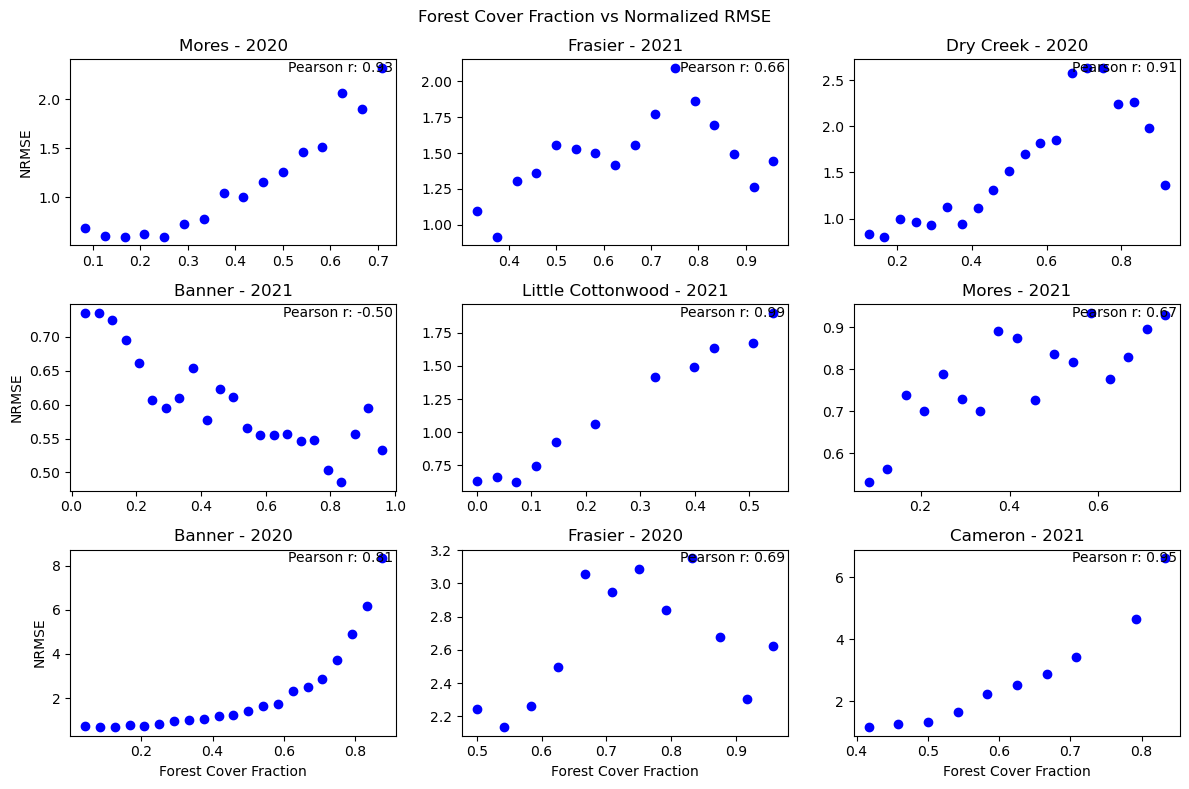

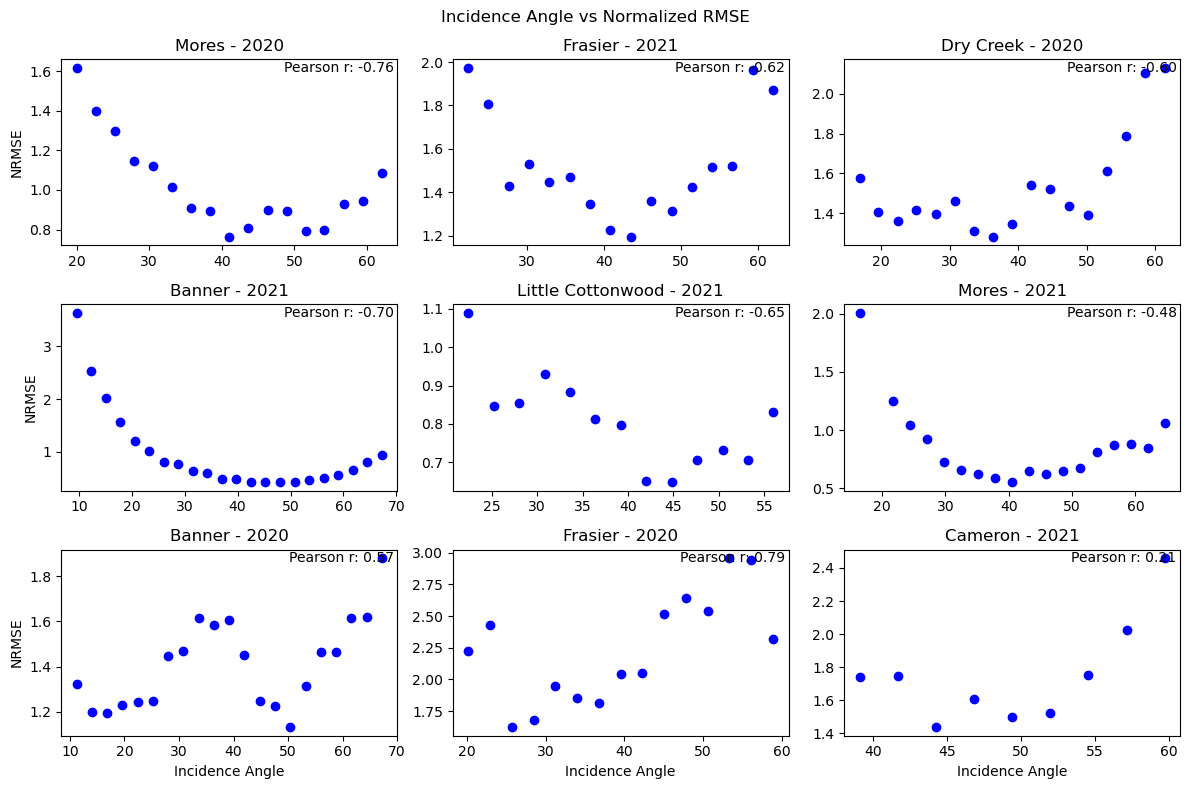

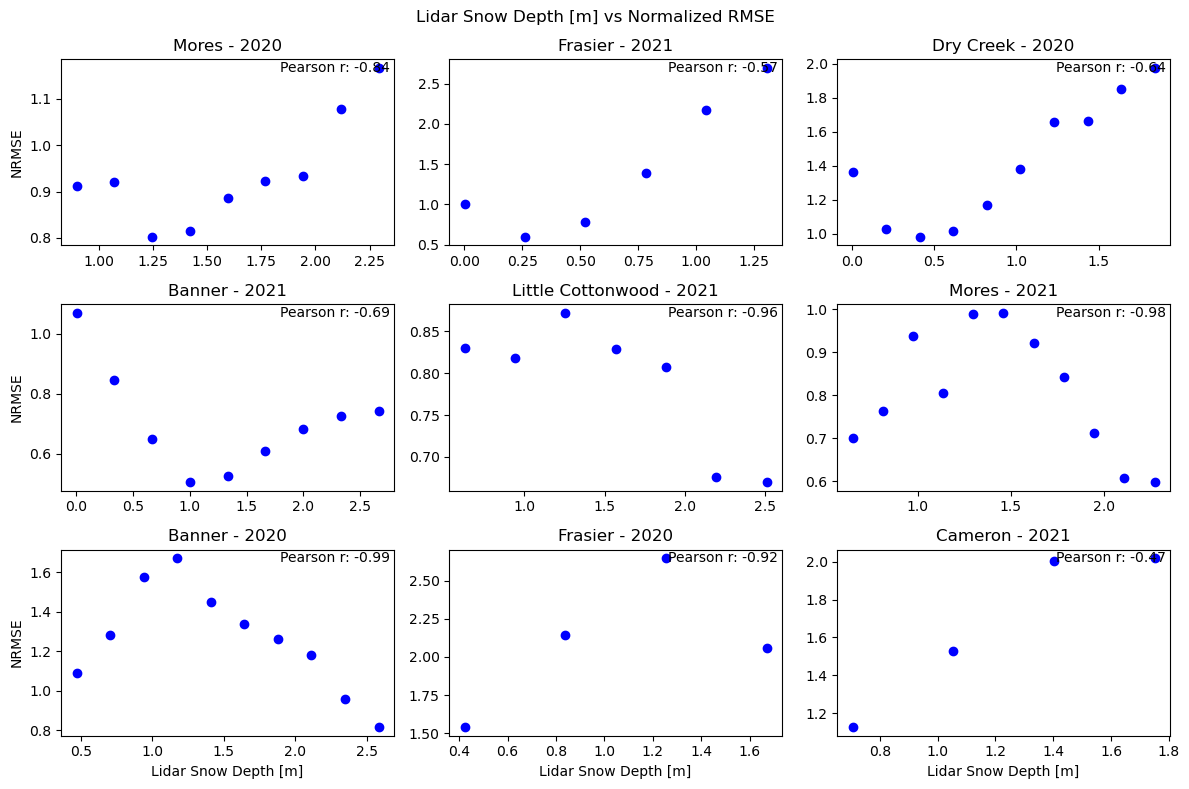

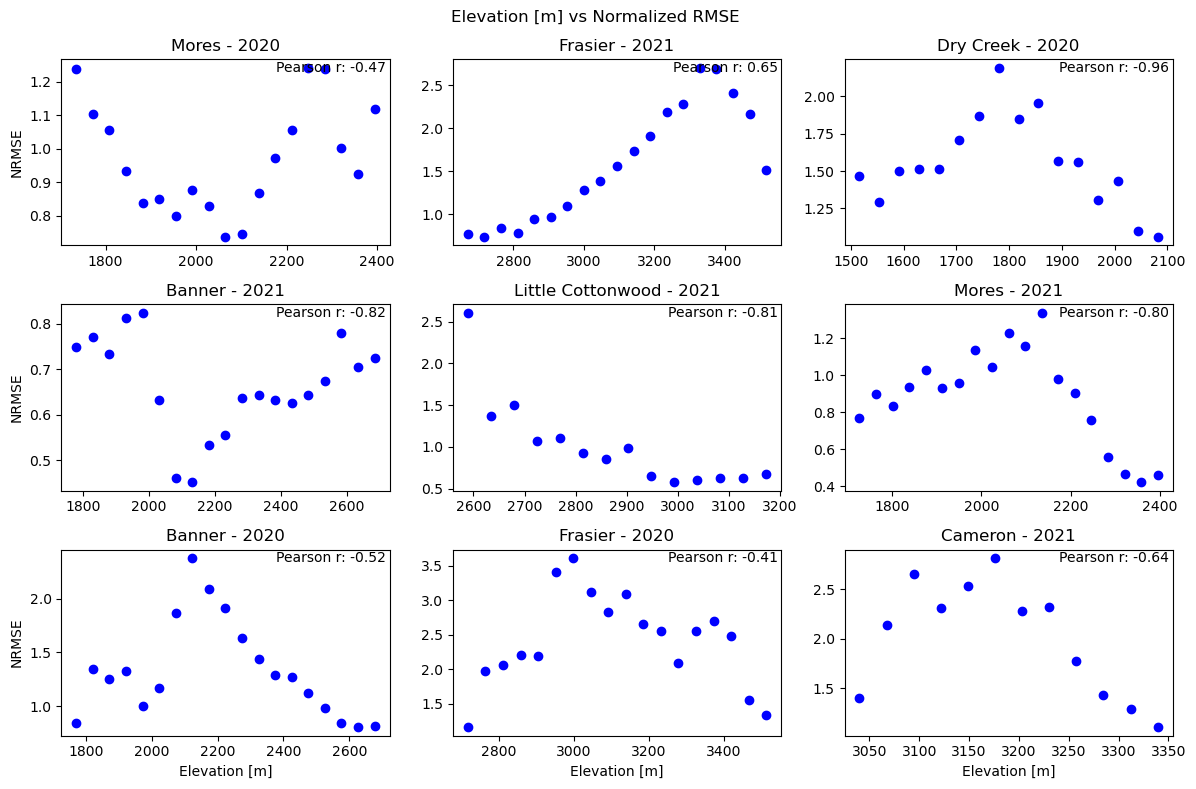

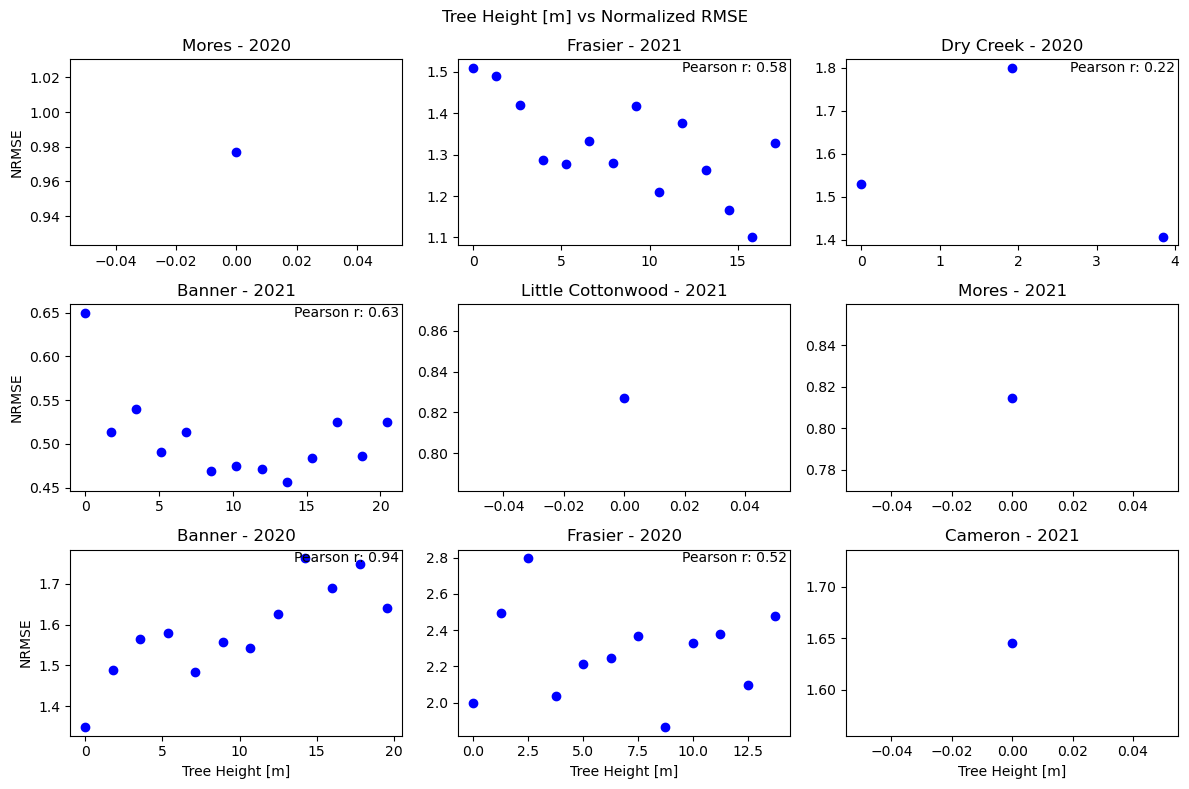

In [42]:
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    fig, axes = plt.subplots(3, 3, figsize = (12,8))
    for ds, ax in zip(dss, axes.ravel()):

        # ds = add_confidence_angle(ds)

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(time_ds[var].min(), time_ds[var].max(), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 100:
                continue
            
            if var == 'fcf' and ds.attrs['site'] == 'Banner' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020 and cat.left > 0.9:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx]) / np.nanmean(y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), rmse_result, color = 'blue')
            else:
                ax.scatter(cat.left, rmse_result, color = 'blue')
            xs.append(cat.left)
            ys.append(rmse_result / np.nanmean(x))
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")

        try:
            stat, r = pearsonr(xs, ys)

            ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)
        except ValueError:
            pass

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('NRMSE')


    plt.suptitle(f'{x_label} vs Normalized RMSE')

    plt.tight_layout()

    figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_rmse.png'))

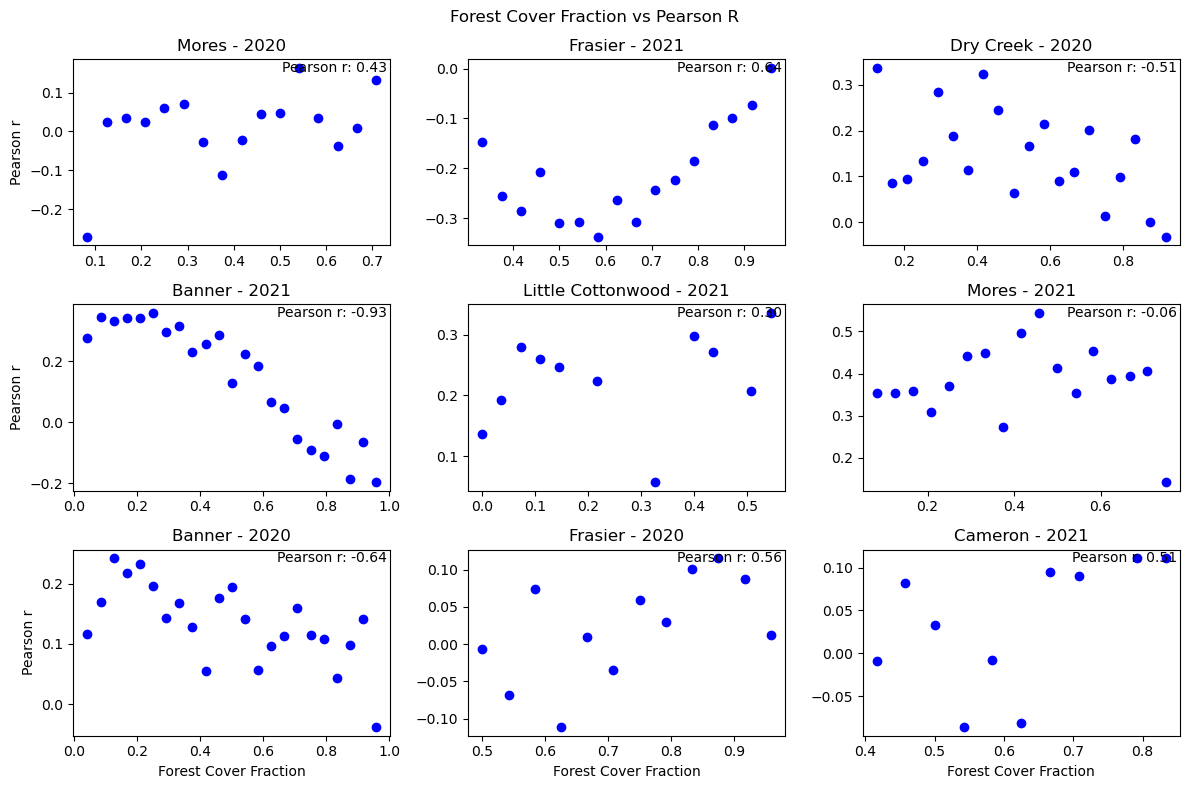

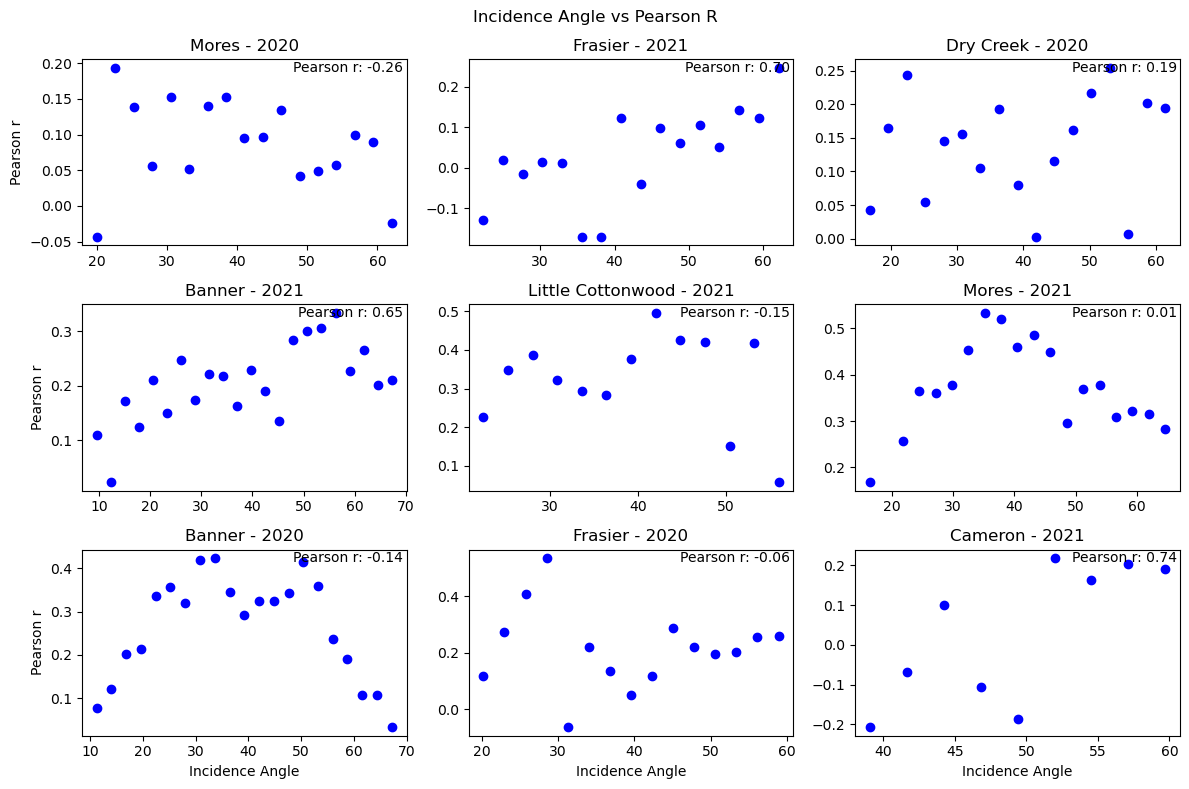

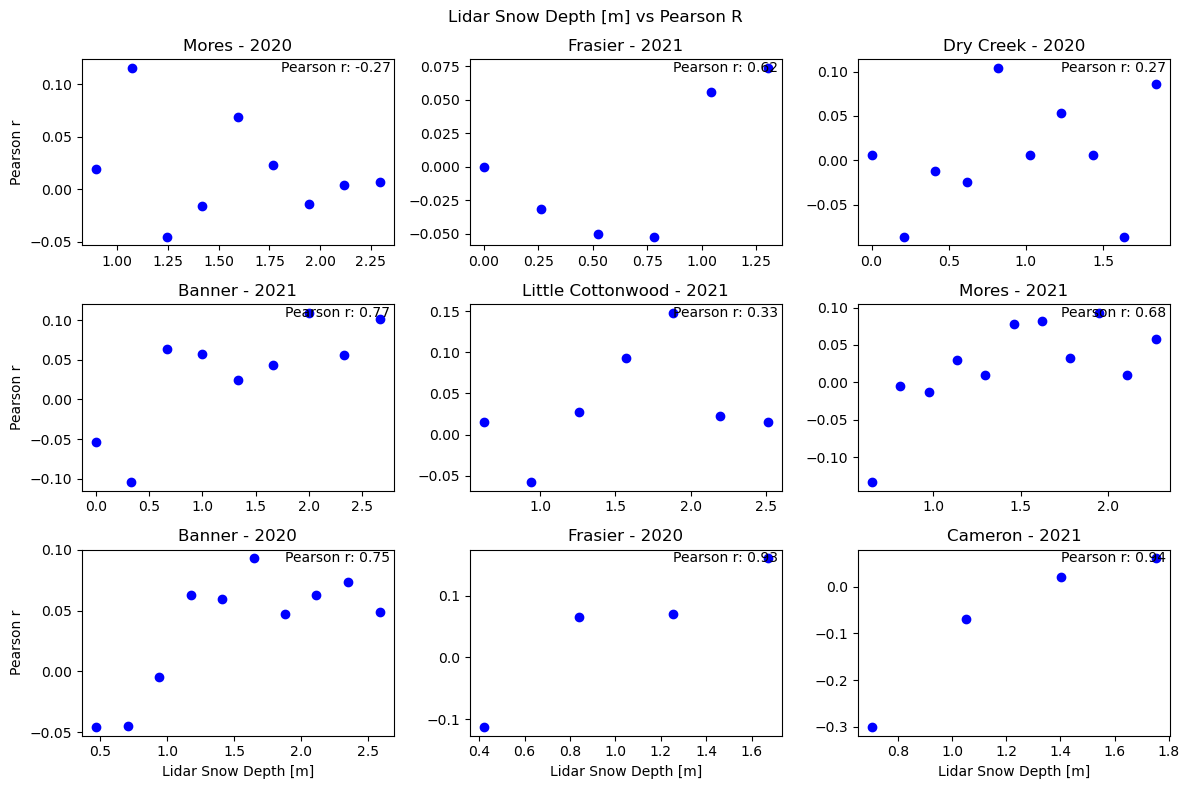

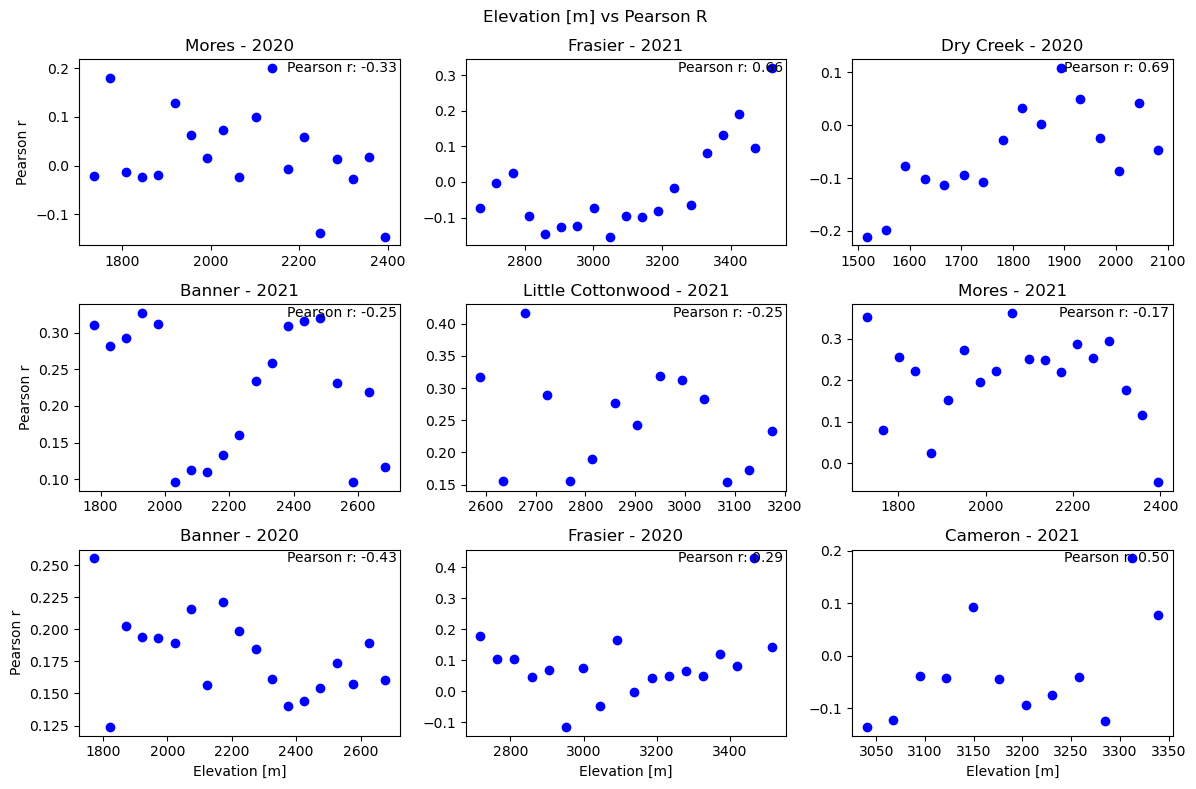

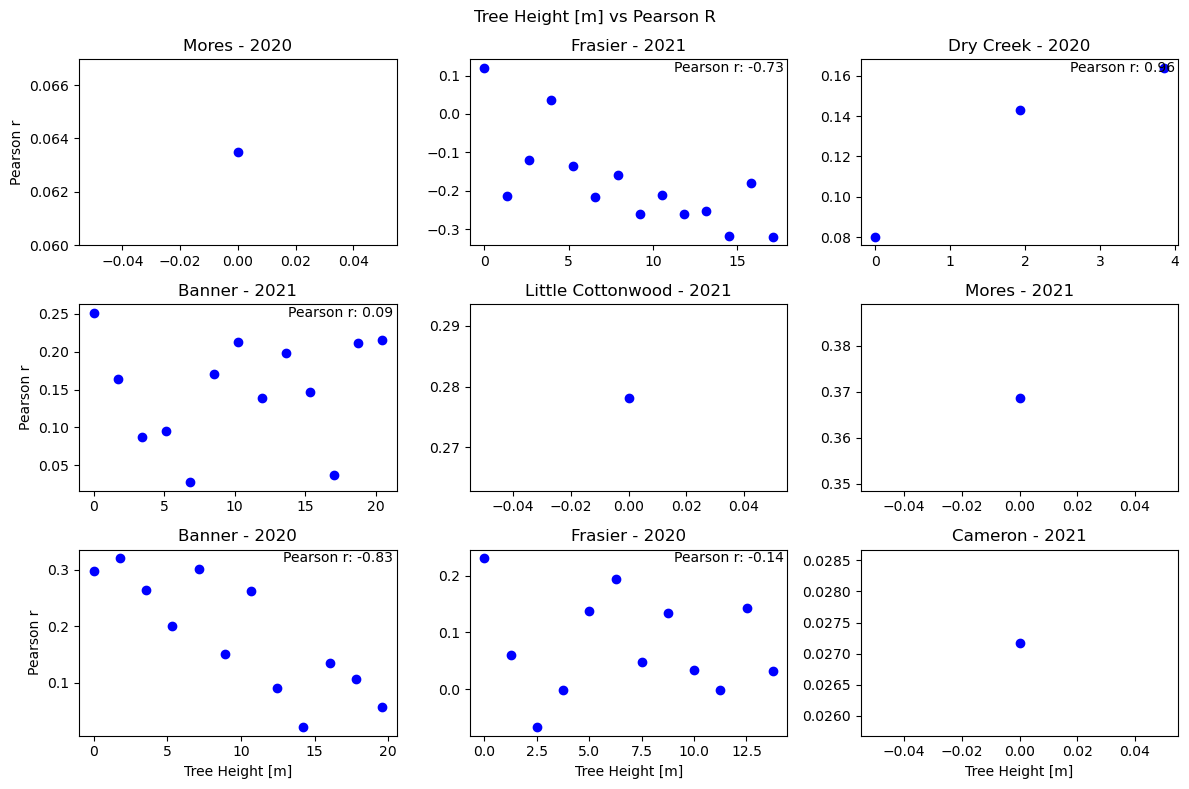

In [17]:
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    fig, axes = plt.subplots(3, 3, figsize = (12,8))
    for ds, ax in zip(dss, axes.ravel()):

        # ds = add_confidence_angle(ds)

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(time_ds[var].min(), time_ds[var].max(), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 100:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), stat, color = 'blue')
            else:
                ax.scatter(cat.left, stat, color = 'blue')
            xs.append(cat.left)
            ys.append(stat)
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")
        
        try:
            stat, r = pearsonr(xs, ys)

            ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)
        except ValueError:
            pass

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('Pearson r')


    plt.suptitle(f'{x_label} vs Pearson R')

    plt.tight_layout()

    figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_pearsonr.png'))